In [1]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import StandardScaler
import pywt
import IPython

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
audio, sr = librosa.load("./Audios/Benjamin_Netanyau/1.wav")

In [5]:
recortado_path = './Audios/Julia_Gillard/1.wav'
IPython.display.Audio(recortado_path)


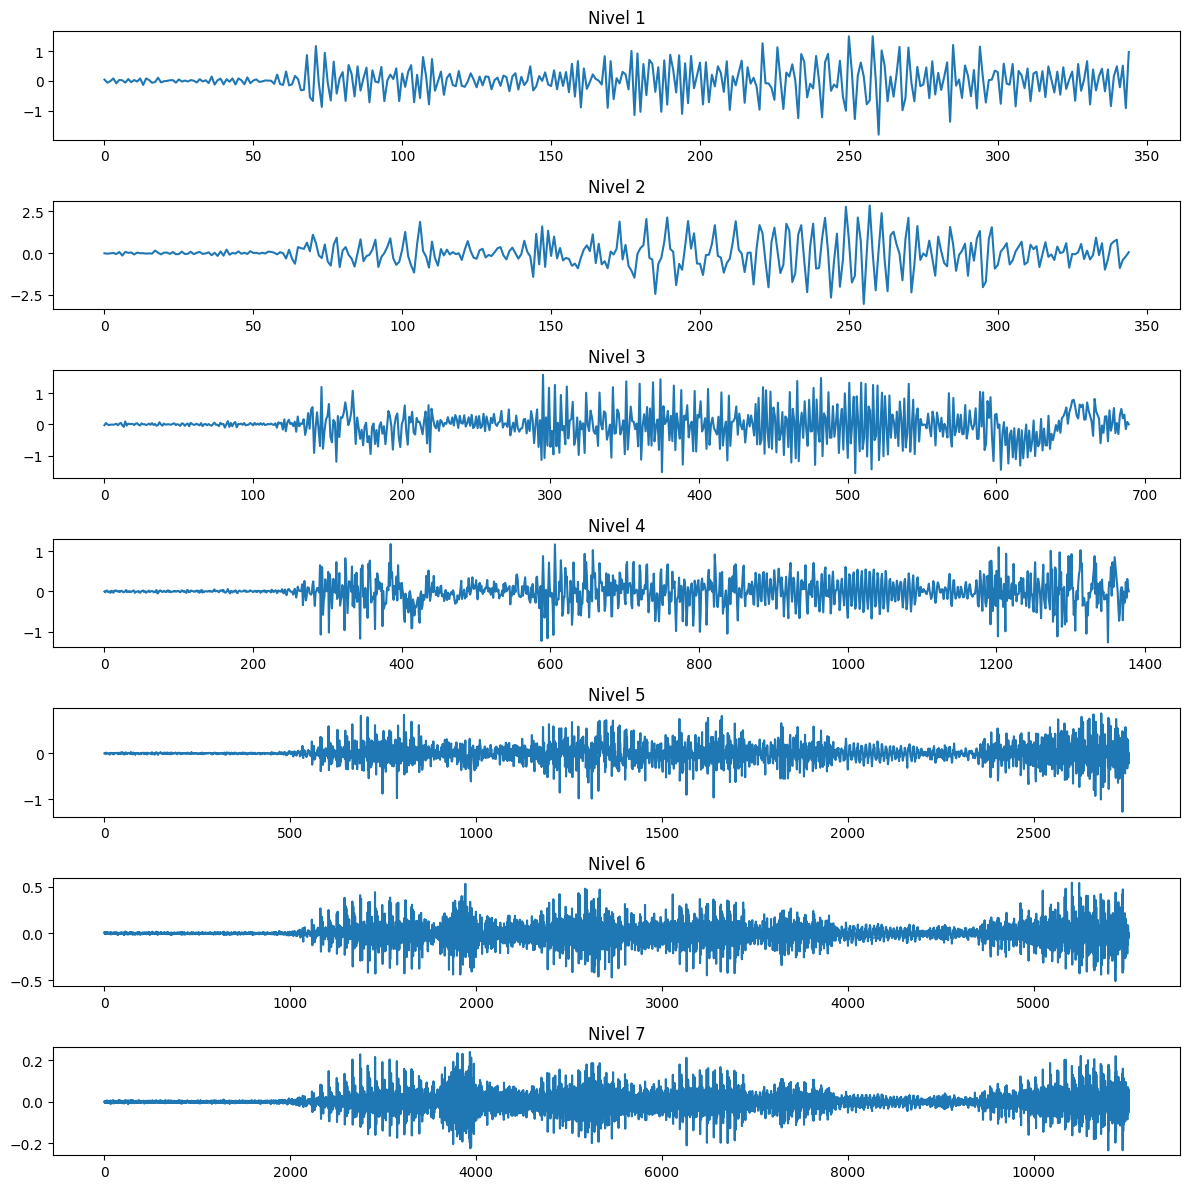

In [6]:
coeffs = pywt.wavedec(audio, 'db1', level=6)
# Visualización de la descomposición
fig, axs = plt.subplots(len(coeffs), 1, figsize=(12, 12))
for i, coeff in enumerate(coeffs):
    axs[i].plot(coeff)
    axs[i].set_title(f'Nivel {i+1}')
plt.tight_layout()
plt.show()

In [7]:
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

In [8]:
# Normalize MFCC features
mfccs = StandardScaler().fit_transform(mfccs)

In [9]:
mfccs.shape

(13, 44)

In [10]:
coeffs_list = []

In [11]:
coeffs = pywt.wavedec(audio, 'db1', level=10)
coeffs_flattened = np.concatenate(coeffs)
coeffs_list.append(coeffs_flattened)

In [12]:
len(np.array(coeffs_list)[0])

22057

In [13]:
# Output directory to clear
ruta = "./Audios"

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

speaker_folders2 = [
    "Prueba"
]

In [14]:
def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

In [15]:
X, y = extract_features(ruta, speaker_folders)

In [16]:
for feature in X[:1]:
    print(feature)

[[-3.32938075e+00  1.11521959e+00  1.52802482e-01  5.33743143e-01
   3.00417274e-01  2.95426548e-01  1.87525675e-01  3.08319658e-01
   5.27314432e-02  1.97137028e-01  4.38123718e-02  1.01487711e-01
   4.07578237e-02]
 [-3.27630877e+00  1.21636605e+00  1.10813431e-01  6.62899196e-01
   3.36590618e-01  3.06007385e-01  8.88402611e-02  3.08643192e-01
   3.31373177e-02  1.46111727e-01  4.11970122e-03  3.43933292e-02
   2.83866599e-02]
 [-3.28899384e+00  1.19158638e+00  1.48881331e-01  6.47298872e-01
   3.22848648e-01  2.75686175e-01  6.15697615e-02  3.32496017e-01
   7.13200271e-02  1.29110768e-01  7.28871161e-03  5.13258241e-02
   4.95813452e-02]
 [-3.28150272e+00  1.21055889e+00  2.25832894e-01  6.60837054e-01
   2.96582758e-01  2.68128783e-01  5.79796508e-02  2.90018886e-01
   9.51710790e-02  1.48068264e-01  7.88654853e-03  1.05757918e-02
   9.86217987e-03]
 [-3.25835800e+00  1.23141873e+00  2.57590681e-01  7.17485487e-01
   3.45809639e-01  2.57110178e-01  4.88723107e-02  2.91667849e-01


In [17]:
import tensorflow as tf

In [18]:
from sklearn.preprocessing import LabelEncoder
# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (5247, 32, 13)
Validation Data Shape: (1124, 32, 13)


In [19]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

c:\Users\clau_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [22]:
# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.6693 - loss: 0.8122 - val_accuracy: 0.8808 - val_loss: 0.2865
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9270 - loss: 0.2127 - val_accuracy: 0.9359 - val_loss: 0.1938
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9471 - loss: 0.1518 - val_accuracy: 0.9591 - val_loss: 0.1283
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9589 - loss: 0.1302 - val_accuracy: 0.9466 - val_loss: 0.1391
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9633 - loss: 0.1094 - val_accuracy: 0.9537 - val_loss: 0.1424


In [23]:
# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

Early stopping triggered at epoch 5


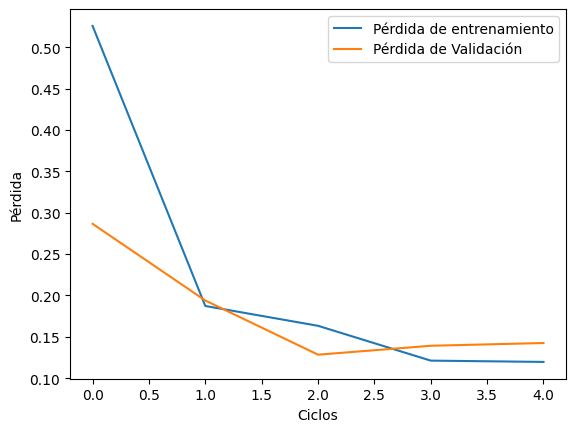

In [29]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Ciclos')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Test Evaluation Accuracy: 0.9564444444444444
Weighted F1 Score: 0.9560144551517817


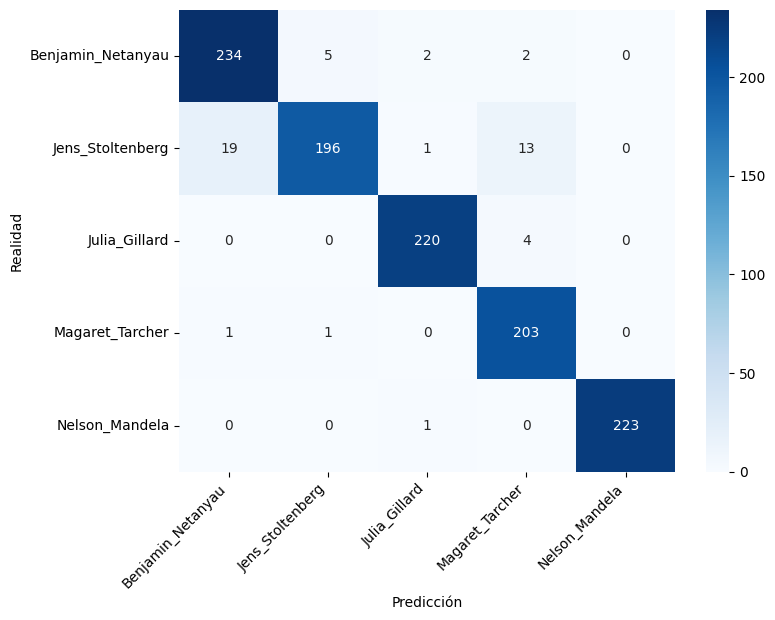

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()